# <center>Детектирование медицинских масок
## <center>Подготовка датасета
Датасет был скачан с [<i><b>Kaggle</b></i>](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

Импортируем необходимые библиотеки

In [77]:
import os
import warnings
import pickle
import time
import pandas as pd
import numpy as np
from multiprocessing import cpu_count
# Personal Dataset class
from data_classes.custom_dataset import DetectionDataset
# DL/ML
import torch
import pytorch_lightning as pl
import albumentations as A
import cv2
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.detection import IntersectionOverUnion, MeanAveragePrecision
from supervision.metrics.detection import ConfusionMatrix
# Visualization
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Plotly configuration
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
# Project constants
torch.set_float32_matmul_precision('high')
DATA_PATH_IMAGES = '../data/images'
DATA_PATH_ANNOTATIONS = '../data/annotations'
BATCH_SIZE = 4
RANDOM_STATE = 42
NN_INPUT = (384, 384)
# Check if GPU available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU_THREADS = cpu_count()
print(f'Available accelerator: {DEVICE}\nTotal CPU threads: {CPU_THREADS}\n')
if DEVICE == 'cuda':
    !nvidia-smi

Available accelerator: cuda
Total CPU threads: 20

Tue Feb  6 22:34:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8             25W /  370W |    1824MiB /  12288MiB |      3%      Default |
|                                         |                        |                  N/A

Создадим объекты датасета для обучающей, валидационной и тестовой выборок с помощью [<b>класса датасета</b>](data_classes/custom_dataset.py)

К обучающей выборке добавим **аугментации**

In [2]:
# ImageNet mean and std
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
normalize = A.Normalize(mean, std)
# Unnormalizer for visualisation
inv_normalize = v2.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)
bbox_params = A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
# Train augmentations
train_transform = A.Compose([
    A.Resize(*NN_INPUT),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.2
    ),
    A.RandomGamma(),
    normalize,
    A.ToFloat()
], bbox_params=bbox_params)
# Val transforms
val_transform = A.Compose([
    A.Resize(*NN_INPUT),
    normalize,
    A.ToFloat()
], bbox_params=bbox_params)
# Lambda func to convert image from normalized torch.float32 to unnormalized torch.uint8 
restore_original_img = lambda img: v2.ToDtype(torch.uint8, scale=True)(inv_normalize(img).permute(1, 2, 0).cpu())
# Initialize datasets
train_dataset = DetectionDataset(
    DATA_PATH_IMAGES, 
    DATA_PATH_ANNOTATIONS,
    split='train',
    transform=train_transform,
    device=DEVICE
)
val_dataset = DetectionDataset(
    DATA_PATH_IMAGES, 
    DATA_PATH_ANNOTATIONS,
    split='val',
    transform=val_transform,
    device=DEVICE
)
test_dataset = DetectionDataset(
    DATA_PATH_IMAGES, 
    DATA_PATH_ANNOTATIONS,
    split='test',
    transform=val_transform,
    device=DEVICE
)
# Print results
print(
    f'Количество обучающих примеров: {len(train_dataset)}',
    f'Количество валидационных примеров: {len(val_dataset)}',
    f'Количество тестовых примеров: {len(test_dataset)}', sep='\n'
)

Количество обучающих примеров: 742
Количество валидационных примеров: 347
Количество тестовых примеров: 350


В каждом объекте датасета есть атрибут `full_df`, который хранит в себе `pandas.DataFrame` из названий изображений, лейблов, ширине, высоте и координатах *bounding box* для **всего датасета**. Также есть `split_df`, в котором хранится информация о примерах для конкретной выборки (`train`, `val`, `test`)

In [3]:
data = train_dataset.full_df
data.head()

name         label  width  height  xmin   ymin  xmax   ymax
0  maksssksksss603.png     with_mask    400     278  49.0   11.0  55.0   17.0
1  maksssksksss603.png     with_mask    400     278  32.0   52.0  40.0   60.0
2  maksssksksss603.png  without_mask    400     278  52.0   76.0  61.0   86.0
3  maksssksksss603.png     with_mask    400     278  47.0   98.0  58.0  109.0
4  maksssksksss603.png     with_mask    400     278  68.0  100.0  75.0  111.0

Визуализируем распределение классов, а также гистограммы для высоты и ширины изображений

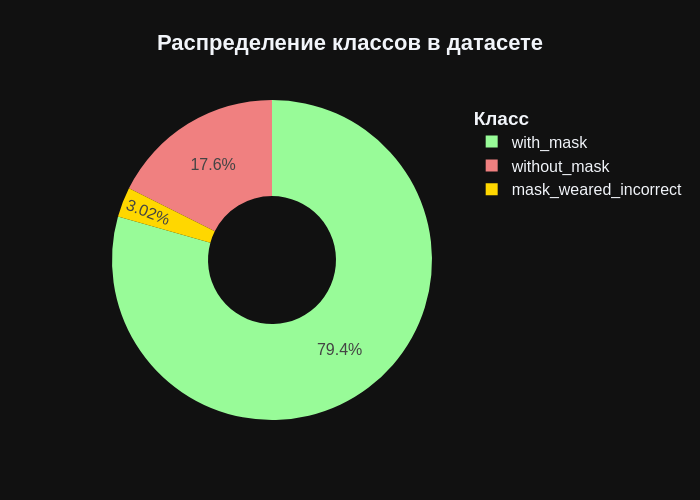

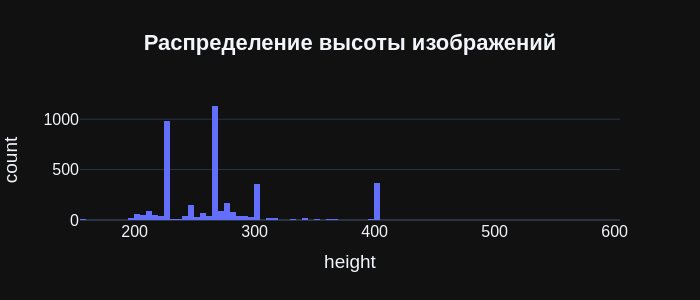

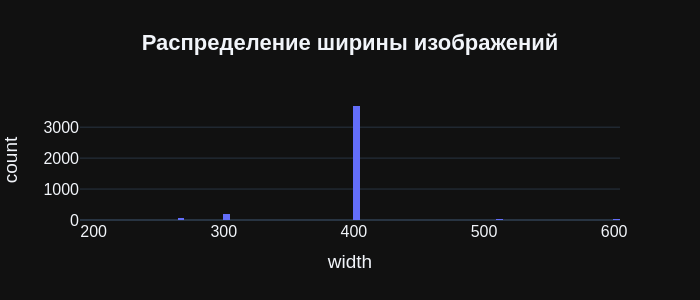

In [4]:
px.pie(
    data_frame=data, 
    names='label', 
    hole=0.4,
    title='<b>Распределение классов в датасете</b>',
    color_discrete_sequence=['PaleGreen', 'LightCoral', 'Gold'],
    height=500,
    width=700
).update_layout(
    legend_title='<b>Класс</b>',
    font=dict(size=16),
    title_x=0.5
).show()

px.histogram(
    data, 
    x='height',
    title='<b>Распределение высоты изображений</b>',
    height=300,
    width=700
).update_layout(
    font=dict(size=16),
    title_x=0.5
).show()

px.histogram(
    data, 
    x='width',
    title='<b>Распределение ширины изображений</b>',
    height=300,
    width=700
).update_layout(
    font=dict(size=16),
    title_x=0.5
).show()

Классы сильно несбалансированы. Есть 2 варианта:
1. Отбалансировать веса с помощью `WeightedRandomSampler` и использовать модель, где в качестве функции потерь для классификации является обычная кросс-энтропия
2. Использовать модель, в которой функция потерь устойчива к несбалансированным датасетам, например $\text{Focal Loss}$

Визуализируем примеры из датасета

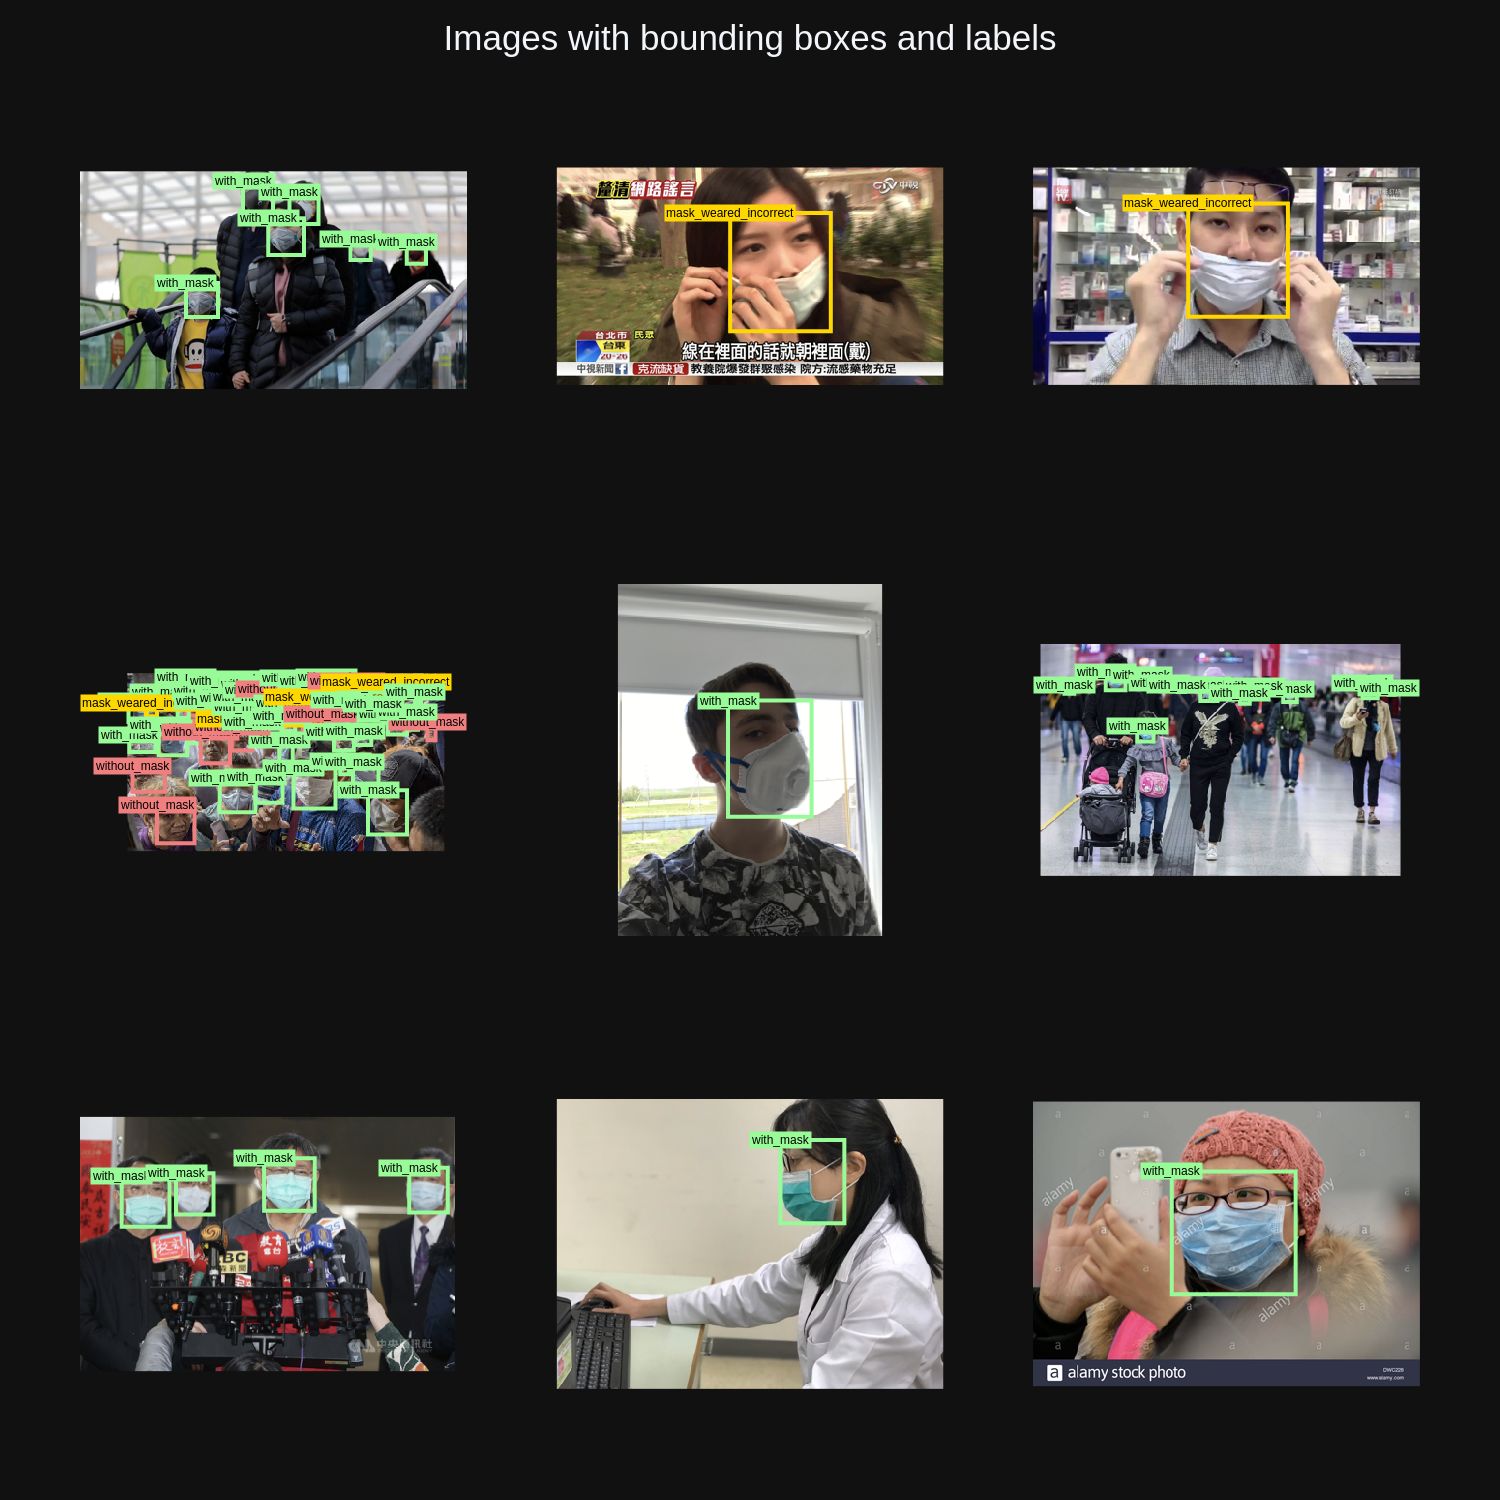

In [5]:
def visualize_dataset_batch(dataset:DetectionDataset, rows=3, cols=3):
    items_df = dataset.full_df
    batch_name_sample = pd.Series(items_df['name'].unique()).sample(rows*cols)
    batch_sample = items_df[items_df['name'].isin(batch_name_sample)]
    # Grid for plots
    grid = make_subplots(
        rows=rows,
        cols=cols,
    )
    iterators = [
        batch_name_sample.values, # total images to display
        sorted(list(range(1, rows + 1)) * cols), # iteration over rows
        list(range(1, cols + 1)) * rows # iteraion over columns
    ]
    for img_name, row, col in zip(*iterators):
        # Read image, convert BGR -> RGB
        image = cv2.imread(os.path.join(DATA_PATH_IMAGES, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Add image to grid
        fig = px.imshow(image)
        grid.add_trace(fig.data[0], row=row, col=col)
        for _, batch_row in batch_sample[batch_sample['name'] == img_name].reset_index(drop=True).iterrows():
            label, xmin, ymin, xmax, ymax = batch_row[['label', 'xmin', 'ymin', 'xmax', 'ymax']].values
            match label:
                case 'with_mask':
                    color = 'PaleGreen'
                case 'without_mask':
                    color = 'LightCoral'
                case 'mask_weared_incorrect':
                    color = 'Gold'
            # Add bbox for image
            grid.add_trace(
                go.Scatter(
                    x=[xmin, xmin, xmax, xmax, xmin],
                    y=[ymin, ymax, ymax, ymin, ymin],
                    mode='lines+text',
                    line=dict(width=4, color=color),
                ), row=row, col=col
            )
            # Add label for image
            grid.add_annotation(
                x=xmin,
                y=ymin,
                bgcolor=color,
                text=label,
                font=dict(color='black', size=12),
                align='left',
                showarrow=False,
                row=row,
                col=col
            )
    # Axes and layout configuration
    grid.update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=1500,
        width=1500,
        title='Images with bounding boxes and labels',
        title_x=0.5,
        font_size=25,
        showlegend=False
    ).show()

visualize_dataset_batch(train_dataset)

## <center>Deep Learning
Будем использовать модель [<i><b>RetinaNet</b></i>](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.retinanet_resnet50_fpn_v2.html), в которой по-умолчанию используется функция потерь $\text{Focal Loss}$, которая хорошо подходит для несбалансированных датасетов

Воспользуемся фреймворком `pytorch-lightning`, который упрощает работу сетями

Начальный `learning_rate` выбран в качестве $10^{-4}$ с экспоненциальным затуханием (после каждой эпохи) при $\gamma=0.95$  
$LR_{i+1} = LR_i \times \gamma \text{, where }i\text{ — epoch}$

Используемые метрики для проверки качества:
* $\text{mAP@50}$ (**целевая метрика**)
* $\text{IoU}$
* $\text{Precision}$
* $\text{Recall}$
* $F_1 \text{-score}$
* $\text{Confusion matrix}$ (для тестовой выборки после обучения и валидации)

In [6]:
class RetinaNet(pl.LightningModule):
    def __init__(
        self, 
        *args, 
        num_classes=3,
        lr=1e-4, 
        gamma=0.95,
        iou_threshold=0.5,
        box_format='xyxy',
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.num_classes = num_classes
        # Learning rate
        self.lr = lr
        # Exponential decay of learning rate per epoch
        self.gamma = gamma
        self.box_format = box_format
        self.iou_threshold = iou_threshold
        # Initialize Retinanet with resnet50 backbone
        self.net = retinanet_resnet50_fpn_v2(
            weights_backbone='DEFAULT',
            num_classes=self.num_classes
        )
        # Metrics
        self.IoU = IntersectionOverUnion(
            box_format=self.box_format,
            iou_threshold=self.iou_threshold
        )
        self.mAP = MeanAveragePrecision(
            box_format=self.box_format, 
            iou_type='bbox', 
            iou_thresholds=[self.iou_threshold],
            extended_summary=True,
            average='macro'
        )
        self.mAP.warn_on_many_detections = False
        
    def forward(self, inputs, target=None):
        # Train step requires inputs and targets
        if target is not None:
            return self.net.train()(inputs, target)
        # Eval step requiers only inputs
        else:
            with torch.no_grad():
                return self.net.eval()(inputs)
    
    def training_step(self, batch, batch_idx):
        inputs, target = batch
        # Train step returns dict of losses
        loss = sum(self.forward(inputs, target).values())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(
            params=self.net.parameters(),
            lr=self.lr,
            weight_decay=1e-2
        )
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=self.gamma)
        return [optimizer], [lr_scheduler]
    
    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        # Get predictions
        outputs = self.forward(inputs)
        # Compute metrics
        iou = self.IoU(outputs, target)['iou']
        # MeanAveragePrecision class can raise warning about max detections per image
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            extended_map_output = self.mAP(outputs, target)
        map_ = extended_map_output['map']
        precision = extended_map_output['precision']
        recall = extended_map_output['recall']
        # precision/recall < 0 is TN, which is not used in detection tasks
        precision = precision[precision >= 0].mean()
        recall = recall[recall >= 0].mean()
        f1_score = 2*precision*recall / (precision+recall)
        # Log metrics
        self.log('IoU', iou, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('mAP', map_, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('Precision', precision, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('Recall', recall, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        self.log('F1-score', f1_score, prog_bar=True, on_epoch=True, logger=True, on_step=False)

    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx)

Инициализируем 3 даталоадера для каждой выборки. В тестовой выборке поставим `batch_size=1` для удобства, когда нужно будет построить матрицу ошибок после получения предсказаний

In [70]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=CPU_THREADS
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CPU_THREADS
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=CPU_THREADS
)

Инициализируем класс модели

In [8]:
retinanet = RetinaNet()

* `logger: CSVLogger` — будем логировать все валидационные метрики после каждой эпохи в файл `./logs/version_*/metrics.csv`
* `lr_monitor: LearningRateMonitor` — добавим логирование `learning_rate` в тот же файл
* `checkpoint_callback: ModelCheckpoint` — сохранение весов модели, показавшей наилучший результат $\text{mAP@50}$ на валидационной выборке 
* `trainer: Trainer` — класс `pytorch_lightning` для удобства обучения модели с прогресс-баром и коллбеками

In [9]:
logger = CSVLogger(save_dir='logs', name='retina_logs', flush_logs_every_n_steps=len(train_loader))
lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(
    dirpath='../models/',
    save_weights_only=True,
    mode='max',
    monitor='mAP'
)

trainer = pl.Trainer(
    max_epochs=30,
    accelerator=DEVICE,
    logger=logger,
    callbacks=[
        lr_monitor, 
        checkpoint_callback
    ],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Обучаем на 30-ти эпохах

In [10]:
trainer.fit(retinanet, train_dataloaders=train_loader, val_dataloaders=val_loader)

Missing logger folder: logs/retina_logs
/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: UserWarning:

Checkpoint directory /home/deep_learning/Detection of medical masks/models exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                  | Params
-----------------------------------------------
0 | net  | RetinaNet             | 36.4 M
1 | IoU  | IntersectionOverUnion | 0     
2 | mAP  | MeanAveragePrecision  | 0     
-----------------------------------------------
36.1 M    Trainable params
225 K     Non-trainable params
36.4 M    Total params
145.493   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/screamer/anaconda3/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Выведем метрики с валидационной выборки, используя лучший чекпоинт

In [11]:
trainer.validate(retinanet, val_loader, ckpt_path='../models/epoch=28-step=5394.ckpt')

Restoring states from the checkpoint path at ../models/epoch=28-step=5394.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/epoch=28-step=5394.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         F1-score          │    0.7837821839252496     │
│            IoU            │    0.8286603689193726     │
│         Precision         │    0.7804798785663081     │
│          Recall           │    0.7874083084517365     │
│            mAP            │    0.9586280584335327     │
└───────────────────────────┴───────────────────────────┘

[{'IoU': 0.8286603689193726,
  'mAP': 0.9586280584335327,
  'Precision': 0.7804798785663081,
  'Recall': 0.7874083084517365,
  'F1-score': 0.7837821839252496}]

Теперь выведем результаты по тестовой выборке

In [12]:
trainer.test(retinanet, test_loader, ckpt_path='../models/epoch=28-step=5394.ckpt')

Restoring states from the checkpoint path at ../models/epoch=28-step=5394.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../models/epoch=28-step=5394.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         F1-score          │    0.7889212717143398     │
│            IoU            │    0.8355206847190857     │
│         Precision         │    0.7883761216127813     │
│          Recall           │    0.7895630659262874     │
│            mAP            │    0.9760873317718506     │
└───────────────────────────┴───────────────────────────┘

[{'IoU': 0.8355206847190857,
  'mAP': 0.9760873317718506,
  'Precision': 0.7883761216127813,
  'Recall': 0.7895630659262874,
  'F1-score': 0.7889212717143398}]

Инициализируем модель с новыми весами

In [13]:
best_retinanet = RetinaNet.load_from_checkpoint('../models/epoch=28-step=5394.ckpt')

Визуализируем историю обучения: как менялись метрики на валидационной выборке с каждой эпохой. `learning_rate` и остальные метрики логгировались не одновременно, поэтому есть пропуски `NaN` в датафрейме, но это никак не помешает корректно визуализировать историю обучения

In [16]:
history = pd.read_csv('./logs/retina_logs/version_0/metrics.csv')
history.head()

Precision       IoU  step  lr-RAdam  epoch    Recall       mAP  F1-score
0        NaN       NaN     0  0.000100    NaN       NaN       NaN       NaN
1   0.199720  0.607834   185       NaN    0.0  0.383512  0.183781  0.256525
2        NaN       NaN   186  0.000095    NaN       NaN       NaN       NaN
3   0.416671  0.623023   371       NaN    1.0  0.562623  0.441333  0.475177
4        NaN       NaN   372  0.000090    NaN       NaN       NaN       NaN

Так как все метрики находятся в одном диапазоне $\{0; 1\}$, то можно отобразить их на одном графике

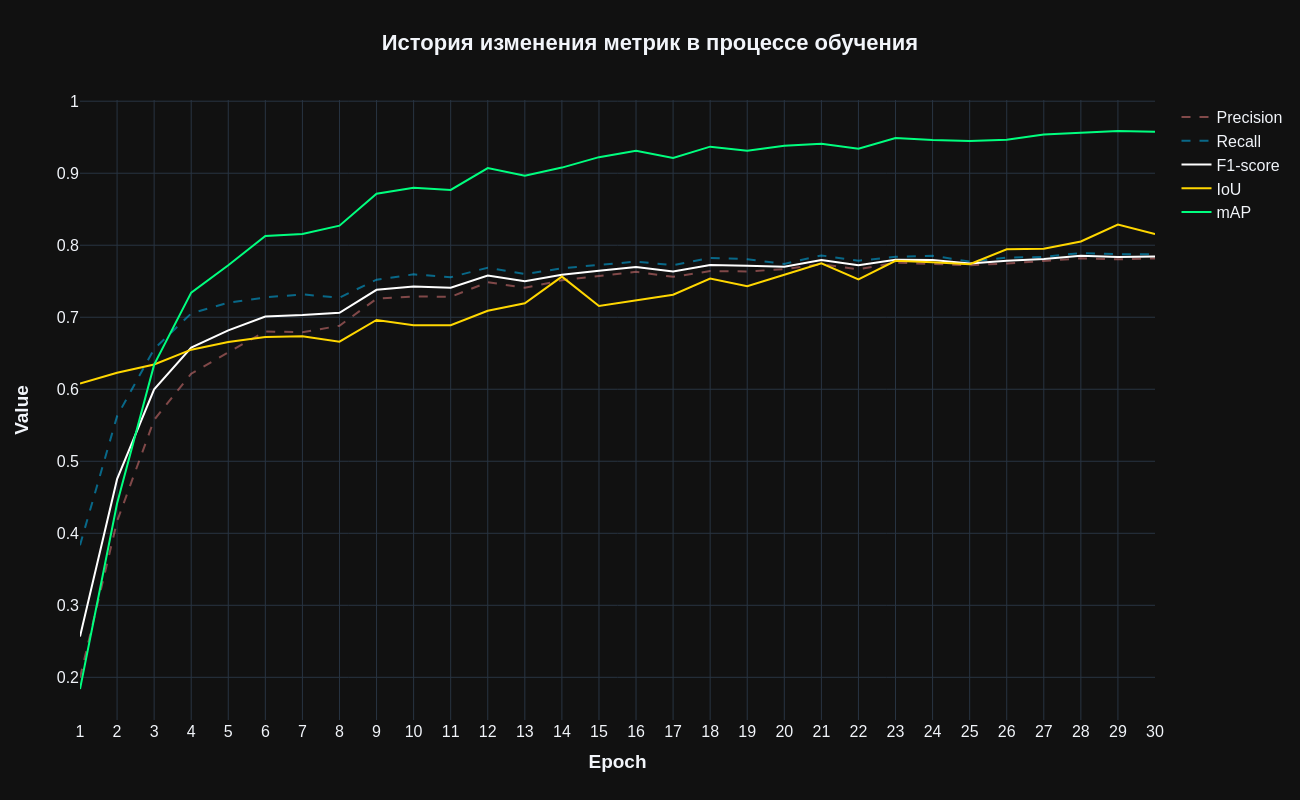

In [55]:
epochs = history['epoch'].dropna().astype(int) + 1
go.Figure(
    go.Scatter(
        x=epochs,
        y=history['Precision'].dropna(),
        name='Precision',
        line=dict(color='#F08080', dash='dash'),
        opacity=0.5
    )
).add_trace(
    go.Scatter(
        x=epochs,
        y=history['Recall'].dropna(),
        name='Recall',
        line=dict(color='#00BFFF', dash='dash'),
        opacity=0.5
    )
).add_trace(
    go.Scatter(
        x=epochs,
        y=history['F1-score'].dropna(),
        name='F1-score',
        line=dict(color='White')
    )
).add_trace(
    go.Scatter(
        x=epochs,
        y=history['IoU'].dropna(),
        name='IoU',
        line=dict(color='#FFD700')
    )
).add_trace(
    go.Scatter(
        x=epochs,
        y=history['mAP'].dropna(),
        name='mAP',
        line=dict(color='#00FF7F')
    )
).update_layout(
    title='<b>История изменения метрик в процессе обучения</b>',
    title_x=0.5,
    xaxis=dict(tickmode='linear', tick0=1, dtick=1, title='<b>Epoch</b>'),
    yaxis=dict(title='<b>Value</b>'),
    height=800,
    width=1300,
    font=dict(size=16)
).show()

Визуализируем несколько предсказаний из тестовой выборки

In [62]:
label_encoder = train_dataset.label_encoder

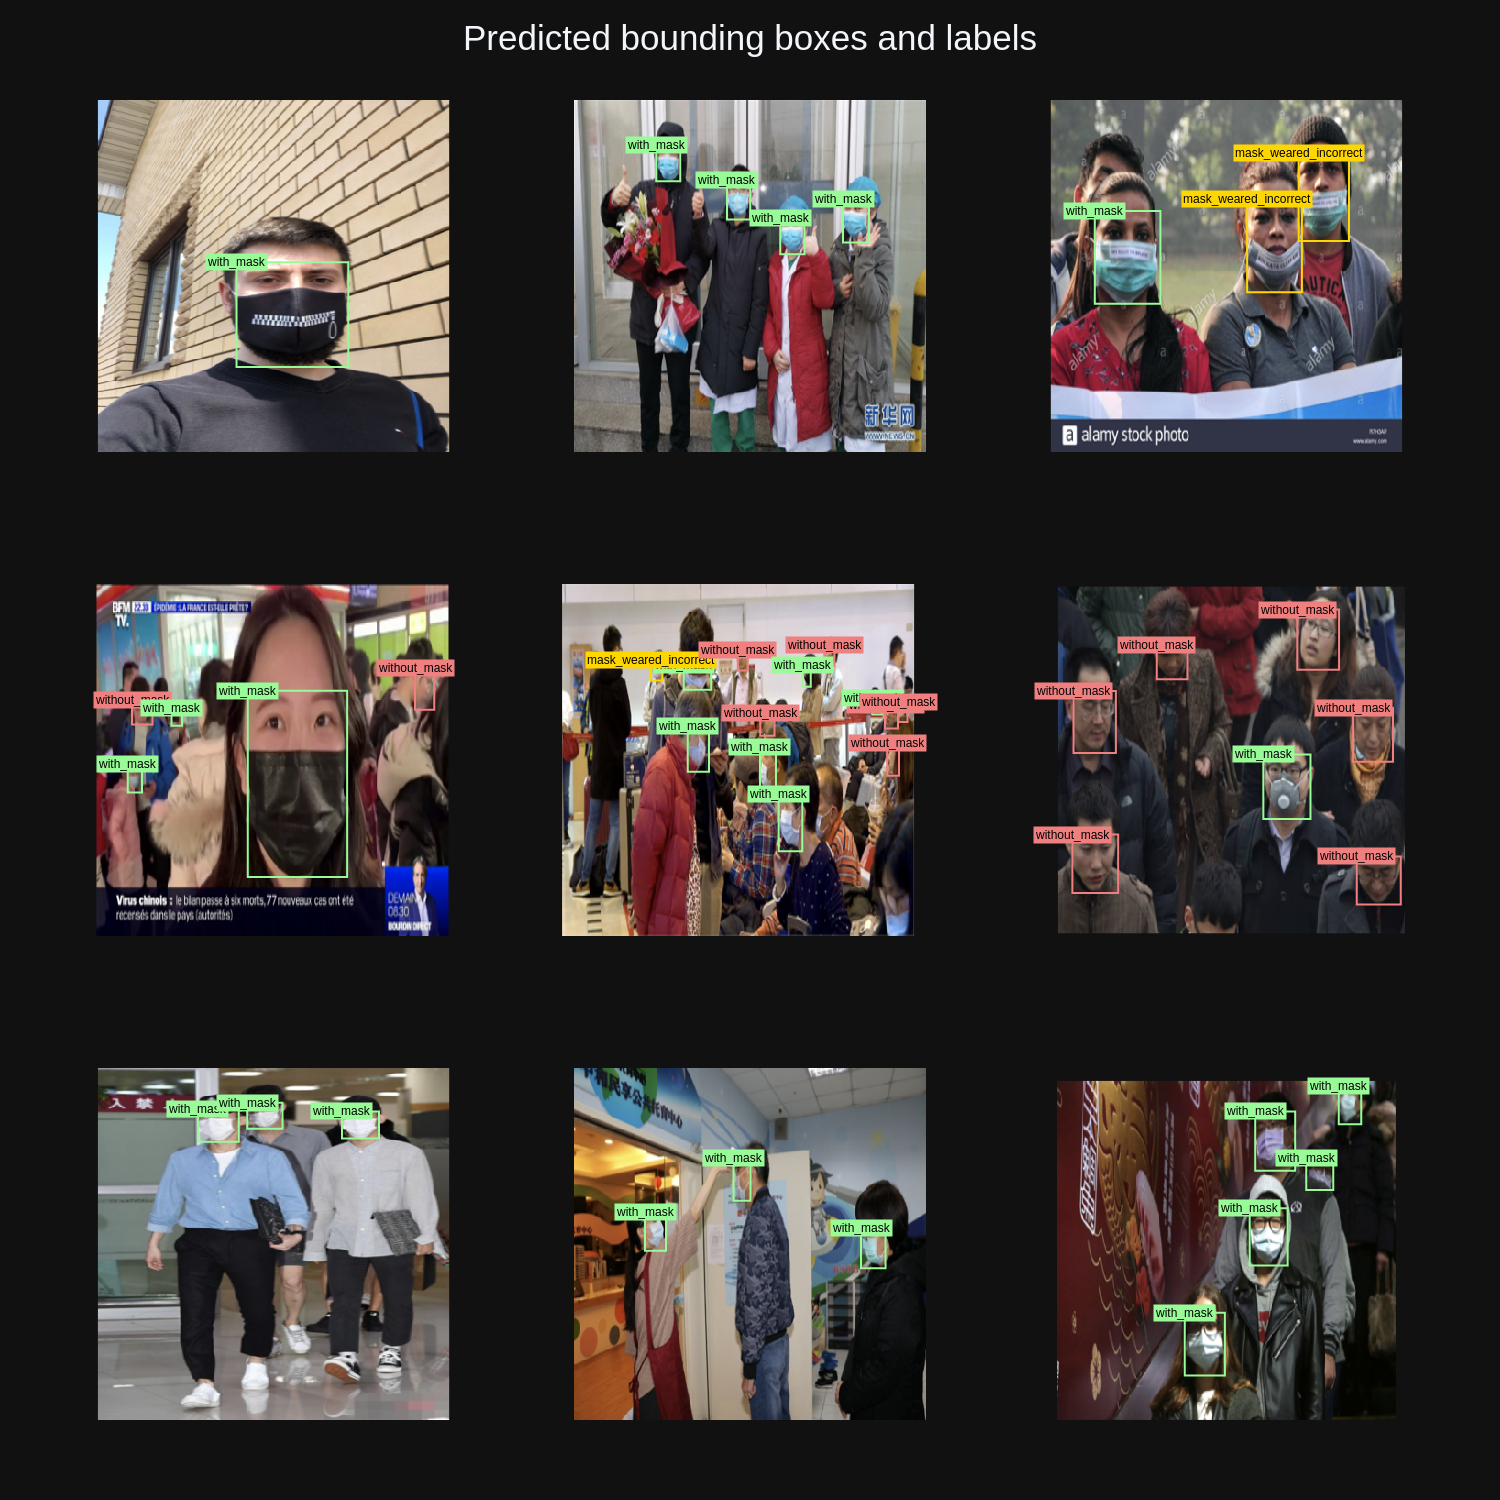

In [74]:
def visualize_predictions(dataloader:DataLoader, model, rows=3, cols=3, threshold=0.5):
    iter_loader = iter(dataloader)
    # Grid for plots
    grid = make_subplots(
        rows=rows,
        cols=cols,
    )
    iterators = [
        iter_loader, # total images to display
        sorted(list(range(1, rows + 1)) * cols), # iteration over rows
        list(range(1, cols + 1)) * rows # iteraion over columns
    ]
    for (img, target_dict), row, col in zip(*iterators):
        # Read image, convert BGR -> RGB
        image = restore_original_img(img[0])
        preds = model.cpu()(img)[0]
        # Add image to grid
        fig = px.imshow(image)
        grid.add_trace(fig.data[0], row=row, col=col)
        for box, score, label in zip(*preds.values()):
            if score < threshold:
                break
            label_text = label_encoder.inverse_transform([label])[0]
            xmin, ymin, xmax, ymax = box
            match label_text:
                case 'with_mask':
                    color = 'PaleGreen'
                case 'without_mask':
                    color = 'LightCoral'
                case 'mask_weared_incorrect':
                    color = 'Gold'
            # Add bbox for image
            grid.add_trace(
                go.Scatter(
                    x=[xmin, xmin, xmax, xmax, xmin],
                    y=[ymin, ymax, ymax, ymin, ymin],
                    mode='lines+text',
                    line=dict(width=2, color=color),
                ), row=row, col=col
            )
            # Add label for image
            grid.add_annotation(
                x=xmin,
                y=ymin,
                bgcolor=color,
                text=label_text,
                font=dict(color='black', size=12),
                align='left',
                showarrow=False,
                row=row,
                col=col
            )
    # Axes and layout configuration
    grid.update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=1500,
        width=1500,
        title='Predicted bounding boxes and labels',
        title_x=0.5,
        font_size=25,
        showlegend=False
    ).show()

visualize_predictions(test_loader, best_retinanet)

In [110]:
best_retinanet.cuda()
conf_matrix = np.zeros((4, 4))
for img, target in test_loader:
    outputs = best_retinanet([img[0].cuda()])
    targets = torch.cat([target[0]['boxes'], target[0]['labels'].reshape(-1, 1)], dim=1).cpu().numpy()
    predictions = torch.cat([outputs[0]['boxes'], outputs[0]['labels'].reshape(-1, 1), outputs[0]['scores'].reshape(-1, 1)], dim=1).cpu().numpy()
    conf_matrix += ConfusionMatrix.from_tensors(
        predictions=[predictions],
        targets=[targets], 
        classes=label_encoder.classes_,
        conf_threshold=0.5,
        iou_threshold=0.6
    ).matrix

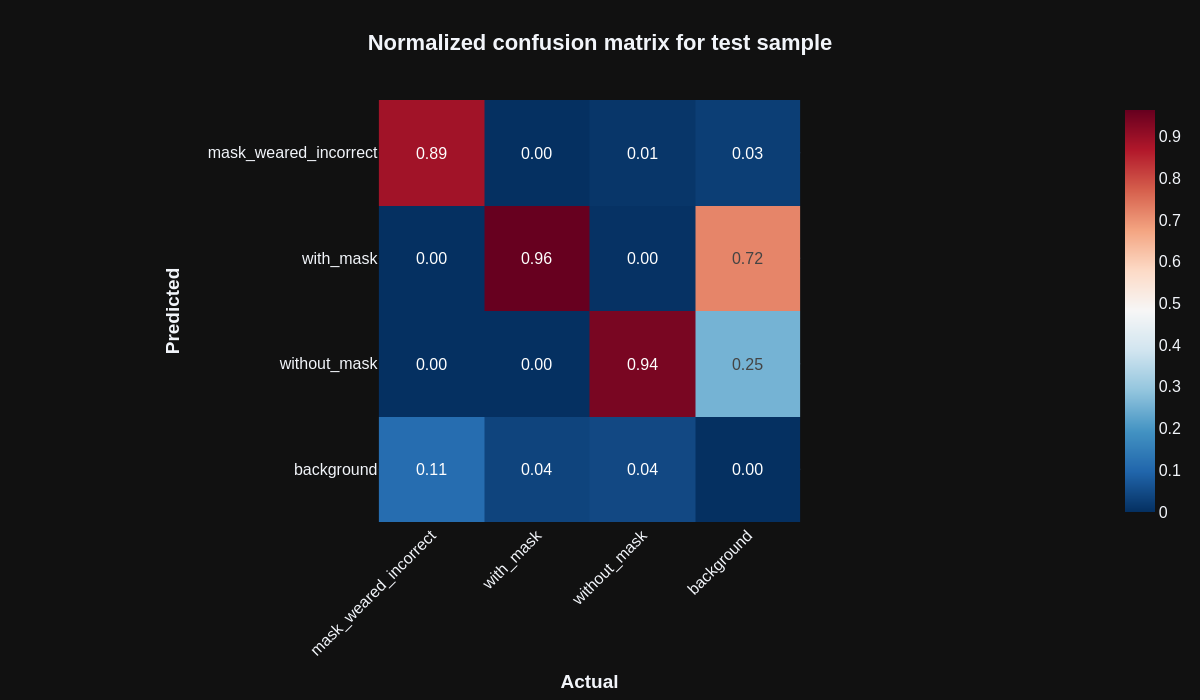

In [111]:
px.imshow(
    conf_matrix / conf_matrix.sum(axis=0),
    x=list(label_encoder.classes_)+['background'],
    y=list(label_encoder.classes_)+['background'],
    color_continuous_scale=px.colors.diverging.RdBu_r,
    text_auto='.2f',
    title='<b>Normalized confusion matrix for test sample</b>',
    height=700,
    width=1200
).update_layout(
    xaxis=dict(title='<b>Actual</b>', tickangle=-45),
    yaxis=dict(title='<b>Predicted</b>'),
    font=dict(size=16),
    title_x=0.5
)

Можно заметить, что между классами модель практически не ошибается, очень мало $\text{FP}$ и $\text{FN}$, однако модель часто принимает `background` (фон) за `with_mask`. Вероятнее всего, дело в том, что в **изначальном датасете не каждое изображение было размечено исчерпывающе**, поэтому модель сама смогла найти людей в маске там, где они есть, но не были размечены в таргете